# Apuntes Cursada Regresion Avanzada

In [1]:
# Fecha Creacion: 02/06/23
# Autor: Andres Montes de Oca

# Instalacion de Paquetes
# !pip install pingouin
# !pip install scipy
# !pip install statsmodels
# !pip install rpy2

# Cargamos Librerias y Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt
# import rpy2.robjects as robjects
# from rpy2.robjects.packages import importr

# Asthetics
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1, color_codes=True)      

## Cargas de Datasets

In [2]:
# Iris para probar las Key Assumptions
dataI = sns.load_dataset('iris')

# Grasa de Cerdos
dataC = pd.read_excel('Data/grasacerdos.xlsx', index_col='Obs') # Cargamos el Dataset
dataC = dataC.replace(to_replace=',', value='.', regex=True) # Reemplazo , por .
dataC = dataC.astype('float') # Transformo en float

# Damascos
# dataD = pd.read_csv('Data/Damascos.csv', index_col='VARIEDAD') # Incompleto

# Dataset para Regresion Lineal
dataP = pd.read_excel('Data/peso_edad_colest.xlsx')

# Modelo Lineal para ejemplos (se en detalle ma abajo)
dataP = sm.add_constant(dataP)
model_colest = smf.ols('colest ~ edad', data=dataP).fit()

# Modelo para Box-Cox usando dataset de cars
dataCars = pd.read_csv('Data/cars.csv')
model_cars = smf.ols('dist ~ speed', data=dataCars).fit()

## Machete

### 1) Linear Relationship
Relationship between independent var (x) and depedent var (y) is linear

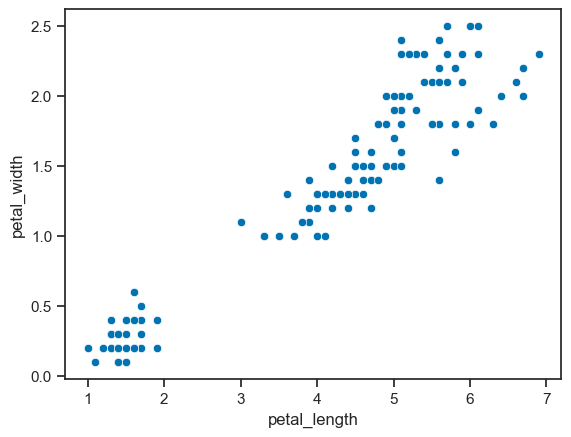

In [3]:
sns.scatterplot(data=dataI, x='petal_length', y='petal_width')
plt.show()

# Transformmations for making relationships linear. Polynomial or Exponential for any of both

### 2) Multicollonearity
Eeach independent variable should be independent from other independent variables

,n,r,CI95%,p-val,BF10,power
pearson,150,0.962865,"[0.95, 0.97]",4.675004e-86,1.113e+82,1.0


C:\Users\andre\AppData\Local\Temp\ipykernel_9308\3067286971.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(sns.heatmap(dataI.corr(), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)) # Todos contra todos


<Axes: >

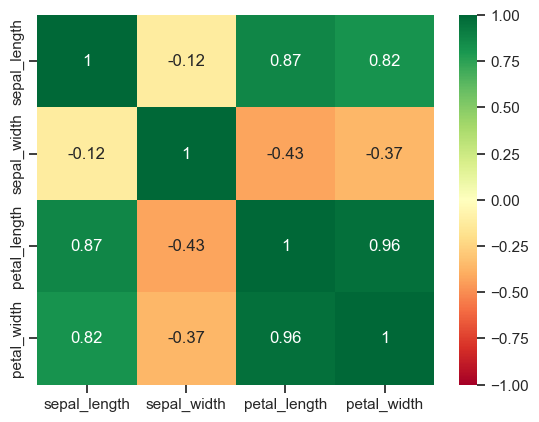

In [4]:
display(pg.corr(dataI['petal_length'], dataI['petal_width'], method='pearson')) # Entre dos varibales, H0 -> Variables Independientes
display(sns.heatmap(dataI.corr(), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)) # Todos contra todos

### 3) Bi-Variate Normality
Multivariate Normality in Variables

HZResults(hz=2.336394200315434, pval=4.1413116299285044e-19, normal=False)


,W,pval,normal
sepal_width,0.984917,0.101126,True


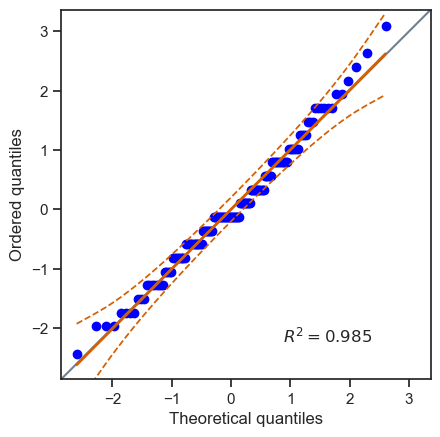

In [5]:
# Test analitico para Multi
print(pg.multivariate_normality(dataI.drop(columns='species'))) # Henze-Zirkler Test, H0 -> Multiv Normal Dist


# Tests analiticos para Single
display(pg.normality(dataI['sepal_width'])) # Shapiro Test(single Var), H0 -> Normal Dist

# Otros tests
# sm.stats.diagnostic.normal_ad(dataI['sepal_width']) # Anderson-Darling StatsModels
# st.anderson(dataI['sepal_width'], dist='norm') # Anderson-Darling SciPy
# st.kstest(dataI['sepal_width'], 'norm')# Kolmogorov-Smirnov SciPy

# Test grafico para Single
pg.qqplot(dataI['sepal_width']) # QQ Plot
plt.show()

### 4) Residuals Normality With 0 Mean
Model residuals should follow a normal distribution, with 0 as mean

In [6]:
# Primero hay que generar el Modelo de Regresion Lineal
display(pg.normality(model_colest.resid))
print('Mean:', model_colest.resid.mean())

# If distribution is not normal, regression results will be biased 
# and it may highlight that there are outliers or other assumptions being violated

,W,pval,normal
0,0.964775,0.517479,True


Mean: 1.5916157281026246e-14


### 5) Residuals Variance (Homosedasticity)
The variance of residual is the same for any value of x

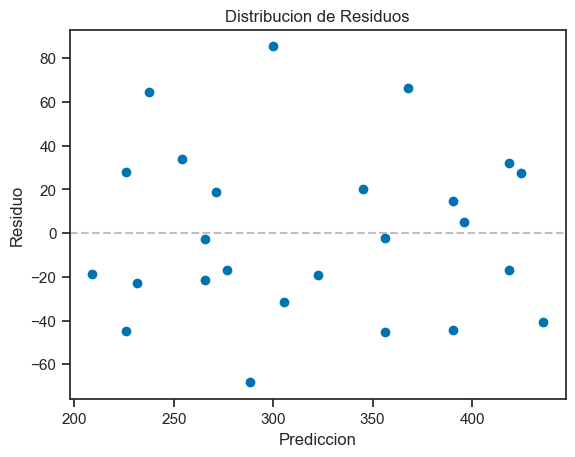

Estadistico BP y p-value: 0.15820998430559619 0.6908099159134533


In [7]:
# Analsis grafico a mano usando Matplotlib
plt.scatter(x=model_colest.predict(), y=model_colest.resid)
plt.xlabel( 'Prediccion')
plt.ylabel('Residuo')
plt.title('Distribucion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()
# No se observa estructura de embudo

# Analitico (Breusch-Pagan Test) -> H0: Residuos Homocedasticos
BP, p_value, _, _ =sm.stats.het_breuschpagan(model_colest.resid, model_colest.model.exog)
print('Estadistico BP y p-value:', BP, p_value)

# sns.residplot(data=dataP, x='edad', y='colest', lowess=True) # Pending
# Test White, Goldfeld-Quandt  Pending

### 6) Correlacion de Residuos
Aleatoriedad en el orden de las observacioens

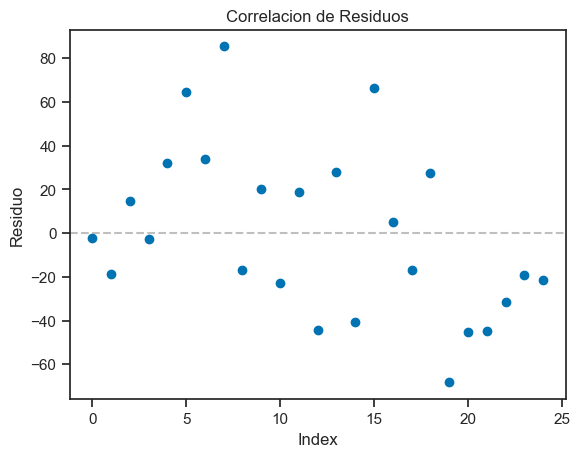

Durbin-Watson: 1.783078813251261


In [8]:
# Analsis grafico a mano usando Matplotlib
plt.scatter(x=dataP.index, y=model_colest.resid)
plt.xlabel( 'Index')
plt.ylabel('Residuo')
plt.title('Correlacion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()
# No se observa estructura

# Durbin-Watson Test: 2=No Correlacion (Independecia?)| 0=Correlacion Pos | 4=Correlacion Neg
print('Durbin-Watson:', sm.stats.durbin_watson(model_colest.resid)) # Sin validacion Estadistica

## 7) Transformacion Box-Cox (pendiente IC e IP)
Cuando los residuos no siguen una distribucion Normal, transformamos la y

ShapiroResult(statistic=0.9450908899307251, pvalue=0.02152523212134838)


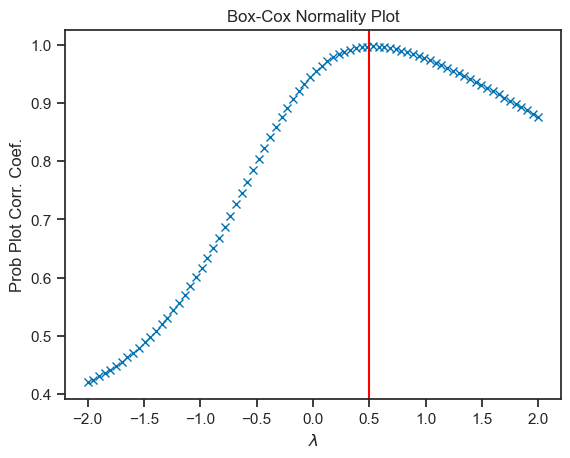

          W      pval  normal
0  0.973323  0.314302    True


In [9]:
# Verificamos la Normalidad de los residuos
print(st.shapiro(model_cars.resid))
data = dataCars
y = data['dist']

# Box-Plot Transformation - Calculo Lambda
maxlog = st.boxcox(y)[1]
st.boxcox_normplot(y, -2, 2, plt)
plt.axvline(maxlog, color='red')
plt.show()

# Transfomracion: Si Lambda  = 0 -> np.log10(y) | y**Lambda
y_trans = pd.Series(y**.5, name='y_trans')
# No olvidarse de anti-transformar para los IC(10**predicted)

# Generamos el nuevo Dataset con la y transformada
data = pd.concat([data, y_trans], axis=1)

# Generamos el nuevo modelo con la y_transformada
model_cars_trans = smf.ols('y_trans ~ speed', data=data).fit()

# Verificamos la nueva normalidad de los residuos
print(pg.normality(model_cars_trans.resid))